In [1]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd

In [3]:
import insolver
from insolver.frame import InsolverDataFrame
from insolver.transforms import FeatureSelection
from insolver.transforms import InsolverTransform
from insolver.transforms import (
    AutoFillNATransforms,
    OneHotEncoderTransforms,
    TransformMapValues,
    EncoderTransforms,
    DatetimeTransforms
)

# Load dataset

Let's load a dataset with the pd.read_csv() and create InsolverDataFrame.

In [7]:
#https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data
dataset = InsolverDataFrame(pd.read_csv("data/AB_NYC_2019.csv"))
dataset.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Information about a loaded dataset.

In [8]:
dataset.info()

<class 'insolver.frame.frame.InsolverDataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review          

Deleting useless columns.

In [9]:
dataset.drop(['id', 'name', 'host_id', 'host_name'], axis = 1, inplace=True)

In [10]:
dataset.info()

<class 'insolver.frame.frame.InsolverDataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   last_review                     38843 non-null  object 
 9   reviews_per_month               38843 non-null  float64
 10  calculated_host_listings_count  48895 non-null  int64  
 11  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(

In [12]:
dataset.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

# Tramsform dataset

Let's tranform all object columns and autofill null values. 

There are 4 object columns:
- `neighbourhood` consists of 221 unique values, for this column I use `EncoderTransforms` that encodes target labels with values between 0 and n_classes-1;
- `neighbourhood_group` consists of 5 unique values, for this column I use `OneHotEncoderTransforms` that encodes categorical features as a one-hot numeric array.
- `room_type` consists of 3 unique values, for this column I use `TransformMapValues` that transforms parameter values according to the given dictionary;
- `last_review` consists of date data, for this column I use `DatetimeTransforms` that preprocesses date and date time columns, it creates new column with the selected datetime feature, unix is used by default.

I use AutoFillNATransforms method to preprocess the NA values:
- For the `numerical_method` parameter I chose 'mean' value which use mean value  
- For the `categorical_method` I chose 'imputed_column' which fills with the frequent category and creates new bool column containing whether a value was imputed or not.

The second AutoFillNATransforms is used to fill the null values created after the OneHotEncoder Transform.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
transform = InsolverTransform(dataset, [
        AutoFillNATransforms(numerical_method = 'mean', categorical_method = 'imputed_column'),
        TransformMapValues('room_type', {'Entire home/apt' : 0, 'Private room' : 1, 'Shared room' : 1}),
        EncoderTransforms(['neighbourhood']),
        OneHotEncoderTransforms(['neighbourhood_group']),
        DatetimeTransforms(['last_review']),
        AutoFillNATransforms(),
        ])
transform.ins_transform();

In [25]:
transform.drop(['last_review'], axis=1, inplace=True)

In [26]:
transform.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Imputed,neighbourhood_Imputed,room_type_Imputed,last_review_Imputed,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,last_review_unix
0,108,40.64749,-73.97237,1.0,149,1,9,0.210000,6,365,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1539907200
1,127,40.75362,-73.98377,1.0,225,1,45,0.380000,2,355,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1558396800
2,94,40.80902,-73.94190,1.0,150,3,0,1.373221,1,365,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1561248000
3,41,40.68514,-73.95976,1.0,89,1,270,4.640000,1,194,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1562284800
4,61,40.79851,-73.94399,1.0,80,10,9,0.100000,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1542585600


# Feature Selection

For the feature selection I will use FeatureSelection class that allows you to compute features importances using selected method. 

Let's use two different selection methods: `random_forest`(used by default), `mutual_inf` and `lasso`.

## Models and plots

**Random Forest**

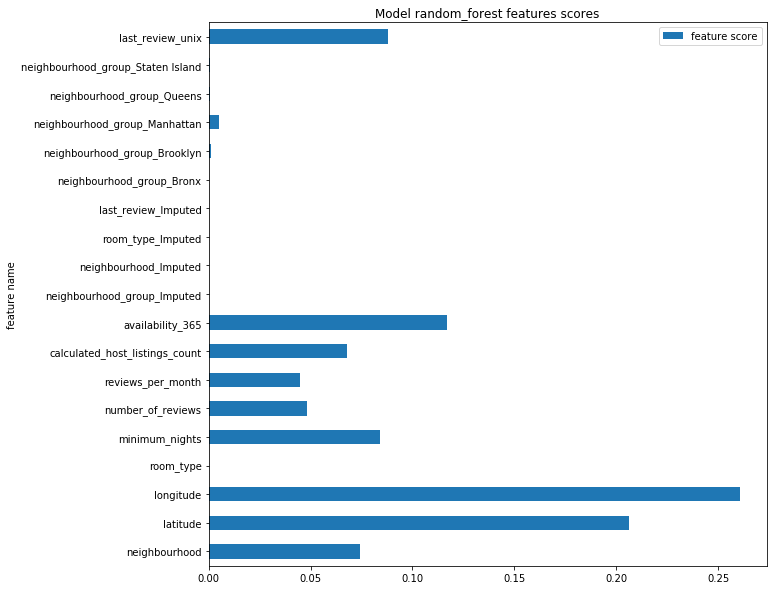

In [32]:
feature_selection = FeatureSelection(y_column='price', task='reg')
feature_selection.create_model(transform)
feature_selection.plot_importance(figsize=(10,10))

Using method plot_importance you can see the most important features in created model. You can change plot size with the `figsize` parameter. It will create (5,5) plot by default.

**Mutual Information**

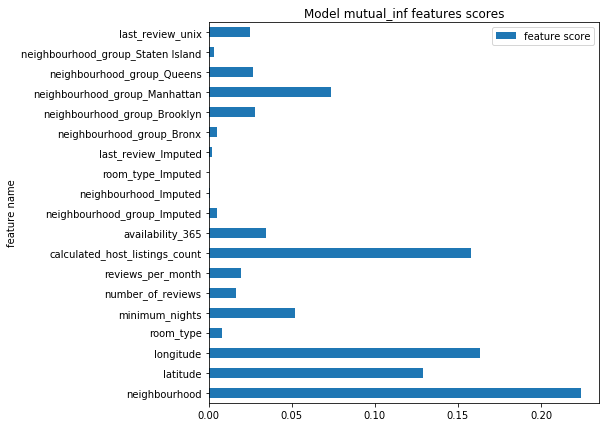

In [46]:
feature_selection = FeatureSelection(method='mutual_inf', y_column='price', task='reg')
feature_selection.create_model(transform)
feature_selection.plot_importance(figsize=(7, 7))

**Lasso**

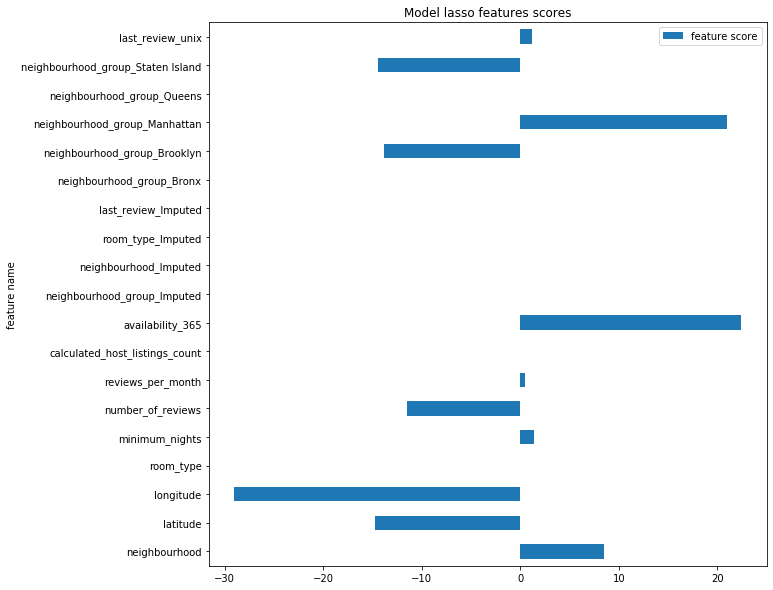

In [38]:
feature_selection = FeatureSelection(method='lasso', y_column='price', task='reg')
feature_selection.create_model(transform)
feature_selection.plot_importance(figsize=(10,10))

## New dataset

You can create plot with the `importance_threshold` parameter and it will create plot only with the values bigger then `importance_threshold`.

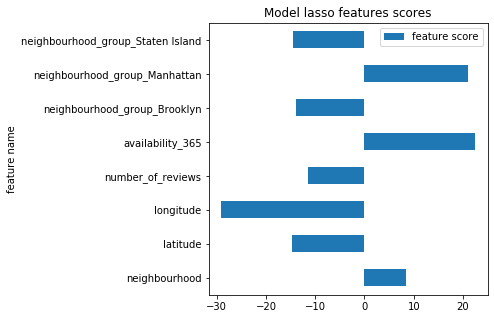

In [39]:
feature_selection.plot_importance(importance_threshold=3)

Let's create new dataset with the selected features only using `threshold = 3`.

In [42]:
new_dataset = feature_selection.create_new_dataset(threshold=3)
new_dataset

,neighbourhood,latitude,longitude,number_of_reviews,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Staten Island,price
0,108,40.64749,-73.97237,9,365,1.0,0.0,0.0,149
1,127,40.75362,-73.98377,45,355,0.0,1.0,0.0,225
2,94,40.80902,-73.94190,0,365,0.0,1.0,0.0,150
3,41,40.68514,-73.95976,270,194,1.0,0.0,0.0,89
4,61,40.79851,-73.94399,9,0,0.0,1.0,0.0,80
...,...,...,...,...,...,...,...,...,...
48890,13,40.67853,-73.94995,0,9,1.0,0.0,0.0,70
48891,28,40.70184,-73.93317,0,36,1.0,0.0,0.0,40
48892,94,40.81475,-73.94867,0,27,0.0,1.0,0.0,115
48893,95,40.75751,-73.99112,0,2,0.0,1.0,0.0,55


You can also create new dataset with the 'mean' (used by default) or 'median' `threshold`.

In [45]:
new_dataset_median = feature_selection.create_new_dataset(threshold='median')
new_dataset_median

,neighbourhood,minimum_nights,availability_365,neighbourhood_group_Manhattan,price
0,108,1,365,0.0,149
1,127,1,355,1.0,225
2,94,3,365,1.0,150
3,41,1,194,0.0,89
4,61,10,0,1.0,80
...,...,...,...,...,...
48890,13,2,9,0.0,70
48891,28,4,36,0.0,40
48892,94,10,27,1.0,115
48893,95,1,2,1.0,55
